# Multiple modes simulation
GenSol integration with Nazca also support simulation of components involving multiple modes. This is a little tricker than simulation involving only one mode, mainly due to the difference in which Nazca and GenSol keep tracks of the different modes. In particular:
- for **GenSol** two modes at the same port are effectively two separate ports, with no relation to each other. The fact that a few ports may share the same physical position is irrelevant (no geometry position is considered in **GenSol**).
- **Nazca** store the physical the connection. Only one pin exist for all the modes that refer to the same physical port.

For this reason, a one to one mapping of the pins between **Nazca** and **GenSol** is not possible if multiple modes are involved. For this reason, the generator of the abstract circuit from **Nazca** will have the following assumptions:
- All the pins in **GenSol** have a name in the form 'basename_modename'  (or possibly, only basename). All pins with the same basename refer to the same physical port, which has that name too. 
- Any operation involving a **Nazca** pin of a certain basename, will be extended to all the **GenSol** pins with the same basenames.
- Some **Nazca** cells have the possibility to generate at runtime scattering matrices with a different number of modes, if the right compact model is defined (the same compact models used by the pathfinder). For now, this is limited to interconnects straight and bends (and all derived functions). This is regulated by setting the `allowed` parameter when calling `get_solver`.
- For models that are provided directly using **GenSol**'s `Model` class, the right number of ports with the right name needs to be provided. 
 
 
## Setting up

### Models built at runtime
In order to allow **GenSol** to automatically built the scattering matrix from a compact model at runtime, a compact model must be defined. In order to do this, a python object on which it is possible to call an Neff function need to be added to `XSection` of the interconnects as the `index` attribute.

Once this is done, in order to generate the scattering matrix with the right modes at runtime, it is enough to call `get_solver` using the `allowed` parameter, which is a 2 level nested dictionary. Each element of the dictionary has the name of the mode as key, and a dictionary of the parameters to feed into the `Neff` function to get the index of the right mode. Calling `get_solver` without `allowed` is equivalent to call it with `allowed= {'' : dict(pol=0, mode=0)}`.

In [1]:
import nazca as nd
from nazca import demofab as demo
import solver as sv
import numpy as np
import matplotlib.pyplot as plt

class DummyIndex:
    def __init(self):
        pass

    def Neff(self, width=3.0, radius=0.0, wl=1.55, pol=0, mode=0, **kwargs):
        if radius == 0:
            return 3.5-0.5*pol-0.1*mode-0.5/(1+width**2)+0.5/wl**2.0
        else:
            return 3.5-0.5*pol-0.1*mode-0.5/(1+width**2)+1.0/(0.2*radius)+0.5/wl**2.0

xs=nd.add_xsection('Shallow')
#xs.index = DummyIndex()



INFO: index.py: Index models version: 0.5.13.post5-110-ge33da01-dev


INFO:solver:version 0.1.0-31-g1bdcb3a-dev
ERROR:solver:repository not clean


INFO: netlist.py: pin2pin drc: True


Once the setup is complete, we can generate a strt cell and see how to get different scattering matrix out of it.

- As aleady stated, the default behavior of `get_solver` is to generate one **GenSol** pin for each **Nazca** one (keeping the same name):

In [2]:
e=demo.shallow.strt(50.0)

S=nd.get_solver(e)
S.solve(wl=1.55).S2PD()

,a0,b0
a0,0.000000+0.000000j,0.999721+0.023620j
b0,0.999721+0.023620j,0.000000+0.000000j


- Calling it with a custom defined `allowed`, will created multiple **GenSol** pins for each **Nazca** one, appending the mode name to the pin name (note that since different options are passed to the Neff function fro the different modes the phase of the scattering matrix elements are different): 

In [3]:
allowed={
    'TE' : dict(pol=0, mode=0),
    'TM'  : dict(pol=1, mode=0)    
}

S=nd.get_solver(e, allowed=allowed)
S.solve(wl=1.55).S2PD()


,a0_TE,a0_TM,b0_TE,b0_TM
a0_TE,0.000000+0.000000j,0.000000+0.000000j,0.999721+0.023620j,0.000000+0.000000j
a0_TM,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.705894-0.708317j
b0_TE,0.999721+0.023620j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
b0_TM,0.000000+0.000000j,0.705894-0.708317j,0.000000+0.000000j,0.000000+0.000000j


### Pre defined models
In case of **GenSol** models directly added to a cell, the models needs to have already the right number of ports with the right names. For example, here is the definition of a polarization insensitive MMI:

In [4]:
MMI = demo.mmi2x2_sh()
MMI.model_info['model'] = sv.GeneralBeamSplitter().expand_mode(['TE','TM'])

MMI.model_info['model'].S2PD(func=np.abs)


,a0_TE,a0_TM,a1_TE,a1_TM,b0_TE,b0_TM,b1_TE,b1_TM
a0_TE,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.707107,0.000000
a0_TM,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.707107
a1_TE,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.707107,0.000000
a1_TM,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.707107
b0_TE,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000
b0_TM,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000
b1_TE,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000
b1_TM,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000


And the one of a Polarization Rotator:

In [5]:
with nd.Cell(name='PolRot') as PR:
    e1 = demo.shallow.taper(width2=5.0, length=10.0)
    e2 = demo.shallow.strt(width=5.0, length=20.0)
    e3 = demo.shallow.taper(width1=5.0, length=10.0)
    nd.Pin('a0', pin=e1.pin['a0']).put()
    nd.Pin('b0', pin=e3.pin['b0']).put()
    nd.put_stub()
    
pin_dic={
    'a0_TE' : 0,
    'a0_TM' : 1,
    'b0_TE' : 2,
    'b0_TM' : 3,
}

S = np.array([
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0]
], dtype=complex)

PR.model_info['model'] = sv.Model(pin_dic=pin_dic, Smatrix=S)
PR.model_info['model'].S2PD(np.abs)



,a0_TE,a0_TM,b0_TE,b0_TM
a0_TE,0.0,0.0,0.0,1.0
a0_TM,0.0,0.0,1.0,0.0
b0_TE,0.0,1.0,0.0,0.0
b0_TM,1.0,0.0,0.0,0.0


### Combination of the 2
The models obtained by `get_solver` could also be used in the building of new models. For example, building a thermal phase shifter with the same dispersion of a conventional waveguide, could be easily built in the following way:

In [6]:
with nd.Cell(name='THPS') as PS:
    t1=demo.metaldc.taper(width2=2.0,length=10.0).put()
    demo.metaldc.strt(90.0,width=2.0).put()
    t2=demo.metaldc.taper(width1=2.0,length=10.0).put()
    
    wg=demo.shallow.strt(100.0).put(5.0,0.0,0.0)
    
    nd.Pin('c0',pin=t1.pin['a0']).put()
    nd.Pin('c1',pin=t2.pin['b0']).put()
    nd.Pin('a0',pin=wg.pin['a0']).put()
    nd.Pin('b0',pin=wg.pin['b0']).put()
    
wave = nd.get_solver(demo.shallow.strt(100.0), allowed=allowed)
with sv.Solver(name='THPS') as S:
    wg = wave.put()
    ps = sv.PhaseShifter().expand_mode(['TE','TM']).put()
    sv.connect_all(wg, 'b0', ps, 'a0')
    sv.raise_pins()
PS.model_info['model'] = S
    

If using this trick, just be careful to call `get_solver` with the same `allowed` parameter as the final call.

## Example: multimode MZI
Here is the example of a multimode MZI (acting as a Polarization Beam splitter at 1.55), which uses the models defined in the previous sections:

INFO: layout.py: Added color to ShallowIcon, (1, 20, None)
INFO: layout.py: Added color to ShallowStub, (1, 10, None)
INFO: layout.py: Added color to ShallowTrenchStub, (2, 10, None)


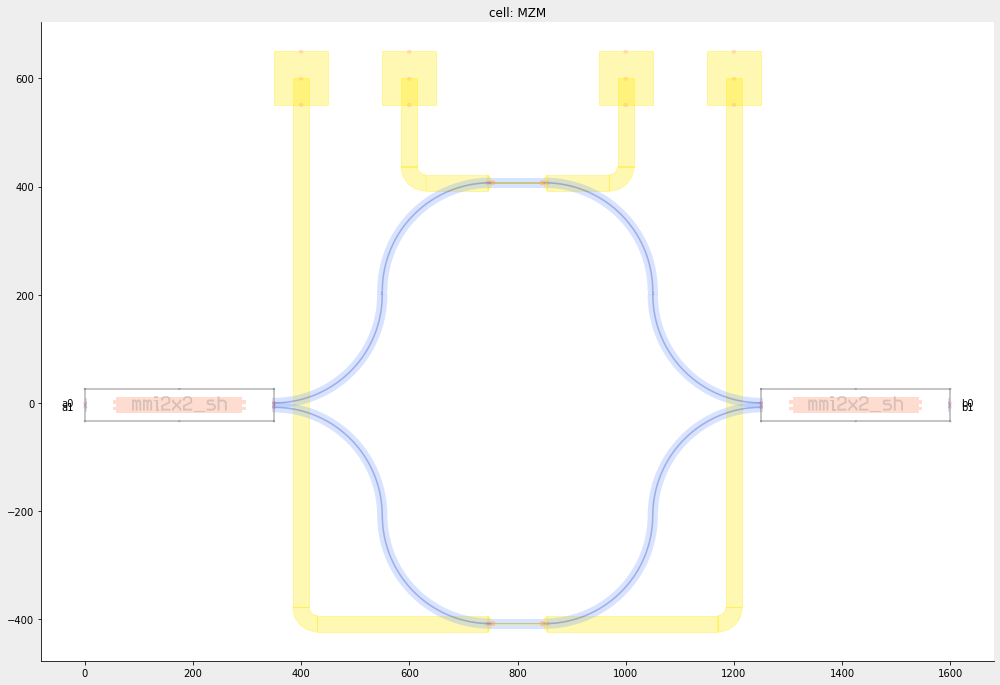

In [7]:
with nd.Cell(name='DC_pad') as DCp:
    demo.metaldc.strt(100.0,width=100.0).put(-50.0,0,0)
    nd.Pin('a0',xs=demo.metaldc.xs).put(0,0,90.0)
    

with nd.Cell(name='MZM') as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=407.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-407.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-400.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=400.0).put()
    
    DCp.put(600.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(1000.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()

    DCp.put(400.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c0']).put()
    DCp.put(1200.0,600.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c1']).put()
    
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('a1',pin=m1.pin['a1']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()
    
nd.export_plt(topcells=MZM_bal)

sol=nd.get_solver(MZM_bal, allowed=allowed)

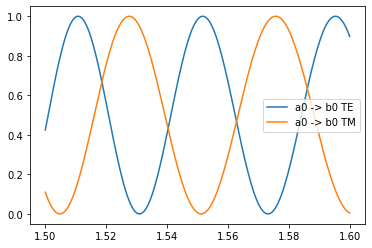

In [8]:
M = sol.solve(wl=np.linspace(1.5,1.6,201))
T = M.get_data('a0_TE', 'b0_TE')
plt.plot(T['wl'], T['T'], label='a0 -> b0 TE')
T = M.get_data('a0_TM', 'b0_TM')
plt.plot(T['wl'], T['T'], label='a0 -> b0 TM')
plt.legend()